# Environment setup

In [1]:
!pip install irc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 2.4 MB/s eta 0:00:00


In [1]:
import os
import re
import time
import socket
import requests
import pandas as pd
from datetime import datetime
from threading import Thread, Lock
import pytz
from google.colab import drive

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ================== Google Drive Mount ==================
drive.mount('/content/drive')

# ================== Configuration ==================
CLIENT_ID = "gp762nuuoqcoxypju8c569th9wz7q5"
OAUTH_TOKEN = "oauth:mb053vdgfqc0u2m7folpig78vgxdke"
USERNAME = "danieljia36"
IRC_SERVER = "irc.chat.twitch.tv"
IRC_PORT = 6667

GAME_LIST = [
    "League of Legends", "Counter-Strike", "Grand Theft Auto V",
    "Assassin's Creed Shadows", "Fortnite", "VALORANT",
    "Marvel Rivals", "Apex Legends", "Rainbow Six Siege"
]

MAX_CHANNELS = 100
OUTPUT_DIR = "/content/drive/MyDrive/twitch_chat_logs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
local_tz = pytz.timezone("Europe/London")

sock = None
sock_lock = Lock()
joined_channels = {}
last_message_time = time.time()

Mounted at /content/drive


# Store data into Google drive

## New version of data aquisition

In [3]:
def get_output_file():
    today = datetime.now(local_tz).strftime("%Y%m%d")
    return os.path.join(OUTPUT_DIR, f"twitch_chat_log_{today}.csv")

def insert_chat_data_batch(rows):
    if not rows:
        return
    output_file = get_output_file()
    if os.path.isdir(output_file):
        print(f"❌ Error: {output_file} is a directory.")
        return
    df = pd.DataFrame(rows)
    file_exists = os.path.isfile(output_file)
    df.to_csv(output_file, mode='a', index=False, encoding='utf-8', header=not file_exists)
    print(f"✅ Appended {len(rows)} rows to {output_file}")

# ================== Twitch IRC Connection ==================
def connect():
    global sock
    while True:
        try:
            s = socket.socket()
            s.settimeout(60)
            s.connect((IRC_SERVER, IRC_PORT))
            s.send(f"PASS {OAUTH_TOKEN}\n".encode("utf-8"))
            s.send(f"NICK {USERNAME}\n".encode("utf-8"))
            print("✅ Connected to Twitch IRC")
            with sock_lock:
                sock = s
            return s
        except Exception as e:
            print(f"⚠️ connect() error: {e}, retrying in 10s")
            time.sleep(10)

# ================== Twitch API ==================
def get_game_ids(game_names):
    headers = {
        "Client-ID": CLIENT_ID,
        "Authorization": f"Bearer {OAUTH_TOKEN.split(':')[1]}"
    }
    game_ids = {}
    for name in game_names:
        response = requests.get("https://api.twitch.tv/helix/games", headers=headers, params={"name": name})
        if response.status_code == 200:
            data = response.json()
            for game in data.get("data", []):
                game_ids[game["name"]] = game["id"]
        else:
            print(f"❌ Failed to get game ID: {name} → {response.text}")
    return game_ids

def get_live_channels(game_ids):
    headers = {
        "Client-ID": CLIENT_ID,
        "Authorization": f"Bearer {OAUTH_TOKEN.split(':')[1]}"
    }
    live_channels = {}
    for game_name, game_id in game_ids.items():
        params = {"game_id": game_id, "first": 20}
        response = requests.get("https://api.twitch.tv/helix/streams", headers=headers, params=params)
        if response.status_code == 200:
            data = response.json()
            live_channels[game_name] = [stream["user_login"] for stream in data.get("data", [])]
        else:
            print(f"❌ Failed to get streams for {game_name}: {response.text}")
    return live_channels

# ================== Channel Connection ==================
def connect_to_channel(s, channel, game_name):
    try:
        s.send(f"JOIN #{channel}\n".encode("utf-8"))
        joined_channels[channel] = game_name
        print(f"✅ Joined channel: {channel} (game: {game_name})")
    except Exception as e:
        print(f"❌ Join error: {channel} → {e}")
        new_sock = connect()
        connect_to_channel(new_sock, channel, game_name)

# ================== Chat Listening ==================
def listen_chat():
    global sock, last_message_time
    buffer = []
    last_flush = time.time()
    while True:
        print("💬 Listening to chat...")
        try:
            with sock_lock:
                s = sock
            try:
                resp = s.recv(2048).decode("utf-8").strip()
            except socket.timeout:
                print("⚠️ 60s no messages, reconnecting...")
                s = connect()
                continue

            if not resp:
                print("⚠️ Empty message, reconnecting...")
                s = connect()
                continue

            last_message_time = time.time()

            if resp.startswith("PING"):
                s.send("PONG :tmi.twitch.tv\n".encode("utf-8"))
                continue

            if "JOIN" in resp:
                print(f"✅ Join confirmation: {resp}")
                continue

            if "PRIVMSG" in resp:
                try:
                    user_name = re.search(r":(\w+)!", resp).group(1)
                    message_match = re.search(r"PRIVMSG #([\w]+) :(.*)", resp)
                    channel = message_match.group(1)
                    chat_message = message_match.group(2)
                    timestamp = datetime.now(local_tz).strftime("%Y-%m-%d %H:%M:%S")
                    game_name = joined_channels.get(channel, "Unknown Game")
                    row = {
                        "timestamp": timestamp,
                        "game_name": game_name,
                        "channel": channel,
                        "user_name": user_name,
                        "message": chat_message
                    }
                    buffer.append(row)
                    if len(buffer) >= 20 or (time.time() - last_flush) >= 5:
                        insert_chat_data_batch(buffer)
                        buffer.clear()
                        last_flush = time.time()
                except Exception as parse_e:
                    print(f"❌ Parse error: {parse_e}")
                    continue

        except (socket.error, BrokenPipeError) as e:
            print(f"⚠️ Connection error: {e}, reconnecting...")
            s = connect()
            continue
        except Exception as e:
            print(f"⚠️ Unexpected error: {e}")
            time.sleep(5)
            continue

# ================== Channel Updater ==================
def update_channels():
    global sock
    game_ids = get_game_ids(GAME_LIST)
    while True:
        if len(joined_channels) >= MAX_CHANNELS:
            print(f"⚠️ Reached max channels {MAX_CHANNELS}, sleeping 5 mins...")
            time.sleep(300)
            continue

        live_channels = get_live_channels(game_ids)
        for game_name, channels in live_channels.items():
            for channel in channels:
                if len(joined_channels) >= MAX_CHANNELS:
                    break
                with sock_lock:
                    s = sock
                if channel not in joined_channels:
                    connect_to_channel(s, channel, game_name)
                    time.sleep(2)
        time.sleep(60)

# ================== Watchdog Thread ==================
def watchdog():
    global sock, last_message_time
    while True:
        if time.time() - last_message_time > 120:
            print("⚠️ 120s no messages, watchdog triggering reconnect...")
            with sock_lock:
                try:
                    sock.close()
                except:
                    pass
                sock = connect()
            last_message_time = time.time()
        time.sleep(30)


In [4]:
# ================== Main Entry ==================
if __name__ == "__main__":
    sock = connect()
    Thread(target=listen_chat, daemon=True).start()
    Thread(target=update_channels, daemon=True).start()
    Thread(target=watchdog, daemon=True).start()
    while True:
        time.sleep(60)


✅ Connected to Twitch IRC
💬 Listening to chat...
💬 Listening to chat...
✅ Joined channel: thebausffs (game: League of Legends)
✅ Join confirmation: :danieljia36!danieljia36@danieljia36.tmi.twitch.tv JOIN #thebausffs
💬 Listening to chat...
💬 Listening to chat...
💬 Listening to chat...
💬 Listening to chat...
💬 Listening to chat...
💬 Listening to chat...
✅ Joined channel: caedrel (game: League of Legends)
✅ Join confirmation: :danieljia36!danieljia36@danieljia36.tmi.twitch.tv JOIN #caedrel
💬 Listening to chat...
💬 Listening to chat...
✅ Joined channel: lol_nemesis (game: League of Legends)
✅ Join confirmation: :danieljia36!danieljia36@danieljia36.tmi.twitch.tv JOIN #lol_nemesis
:danieljia36.tmi.twitch.tv 353 danieljia36 = #lol_nemesis :danieljia36
:danieljia36.tmi.twitch.tv 366 danieljia36 #lol_nemesis :End of /NAMES list
💬 Listening to chat...
✅ Appended 6 rows to /content/drive/MyDrive/twitch_chat_logs/twitch_chat_log_20250512.csv
💬 Listening to chat...
💬 Listening to chat...
💬 Listenin

KeyboardInterrupt: 

## Old version

In [4]:
def connect():
    global sock
    while True:
        try:
            s = socket.socket()
            s.settimeout(60)
            s.connect((IRC_SERVER, IRC_PORT))
            s.send(f"PASS {OAUTH_TOKEN}\n".encode("utf-8"))
            s.send(f"NICK {USERNAME}\n".encode("utf-8"))
            print("✅ connected to Twitch IRC")
            with sock_lock:
                sock = s
            return s
        except Exception as e:
            print(f"⚠ connection failed，try again in 10s...: {e}")
            time.sleep(10)

OUTPUT_FILE = "/content/drive/MyDrive/twitch_chat_logs/twitch_chat_log20250509.csv"
def insert_chat_data_batch(rows):
    """ 追加聊天数据到同一个 CSV 文件 """
    if not rows:
        return
    df = pd.DataFrame(rows)
    # 检查文件是否存在
    file_exists = os.path.isfile(OUTPUT_FILE)
    # 追加写入，第一次写入时带 header，之后不带 header
    df.to_csv(OUTPUT_FILE, mode='a', index=False, encoding='utf-8', header=not file_exists)
    print(f"✅ inserted {len(rows)} of data into {OUTPUT_FILE}")

def get_game_ids(game_names):
    headers = {
        "Client-ID": CLIENT_ID,
        "Authorization": f"Bearer {OAUTH_TOKEN.split(':')[1]}"
    }
    game_ids = {}
    for name in game_names:
        response = requests.get(GAMES_API_URL, headers=headers, params={"name": name})
        if response.status_code == 200:
            data = response.json()
            for game in data.get("data", []):
                game_ids[game["name"]] = game["id"]
        else:
            print(f"failed to get game id ({name}): {response.text}")
    return game_ids

def get_live_channels(game_ids):
    headers = {
        "Client-ID": CLIENT_ID,
        "Authorization": f"Bearer {OAUTH_TOKEN.split(':')[1]}"
    }
    live_channels = {}
    for game_name, game_id in game_ids.items():
        params = {"game_id": game_id, "first": 20}
        response = requests.get(API_URL, headers=headers, params=params)
        if response.status_code == 200:
            data = response.json()
            live_channels[game_name] = [stream["user_login"] for stream in data.get("data", [])]
        else:
            print(f"get {game_name} stream list failed: {response.text}")
    return live_channels

def connect_to_channel(s, channel, game_name):
    try:
        s.send(f"JOIN #{channel}\n".encode("utf-8"))
        joined_channels[channel] = game_name
        print(f"joined channel: {channel} (game: {game_name})")
    except Exception as e:
        print(f"join channel {channel} fail: {e}")
        new_sock = connect()
        connect_to_channel(new_sock, channel, game_name)


# Max channel number
MAX_CHANNELS = 100

# the last timestamp received
last_message_time = time.time()

def listen_chat():
    global sock, last_message_time
    buffer = []
    last_flush = time.time()
    while True:
        print("💬 Listening to chat...")
        try:
            with sock_lock:
                s = sock
            try:
                resp = s.recv(2048).decode("utf-8").strip()
            except socket.timeout:
                print("⚠️ socket timeout，reconnecting...")
                s = connect()
                continue

            if not resp:
                print("⚠️ empty message，reconnecting...")
                s = connect()
                continue

            last_message_time = time.time()

            if resp.startswith("PING"):
                s.send("PONG :tmi.twitch.tv\n".encode("utf-8"))
                continue

            if "JOIN" in resp:
                print(f"✅ Joined channel: {resp}")
                continue

            if "PRIVMSG" in resp:
                try:
                    user_name = re.search(r":(\w+)!", resp).group(1)
                    message_match = re.search(r"PRIVMSG #([\w]+) :(.*)", resp)
                    channel = message_match.group(1)
                    chat_message = message_match.group(2)
                    timestamp = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")
                    game_name = joined_channels.get(channel, "Unknown Game")
                    row = {
                        "timestamp": timestamp,
                        "game_name": game_name,
                        "channel": channel,
                        "user_name": user_name,
                        "message": chat_message
                    }
                    buffer.append(row)
                    if len(buffer) >= 20 or (time.time() - last_flush) >= 5:
                        insert_chat_data_batch(buffer)
                        buffer.clear()
                        last_flush = time.time()
                except Exception as parse_e:
                    print(f"❌ Parse message filed: {parse_e}")
                    continue

        except (socket.error, BrokenPipeError) as e:
            print(f"⚠️ Connection error: {e}，reconnecting...")
            s = connect()
            continue
        except Exception as e:
            print(f"⚠️ Unknown error in listening process: {e}")
            time.sleep(5)
            continue

def update_channels():
    global sock
    game_ids = get_game_ids(GAME_LIST)
    while True:
        live_channels = get_live_channels(game_ids)
        for game_name, channels in live_channels.items():
            for channel in channels:
                if len(joined_channels) >= MAX_CHANNELS:
                    print(f"⚠️ Reached maximum channels {MAX_CHANNELS}，stop joining new channels")
                    break
                with sock_lock:
                    s = sock
                if channel not in joined_channels:
                    connect_to_channel(s, channel, game_name)
                    time.sleep(2)
        time.sleep(60)

def watchdog():
    global sock, last_message_time
    while True:
        if time.time() - last_message_time > 120:
            print("⚠️ 120 s no new messages，force to reconnect...")
            with sock_lock:
                try:
                    sock.close()
                except Exception:
                    pass
                sock = connect()
            last_message_time = time.time()
        time.sleep(30)  # check every 30s

In [ ]:

if __name__ == "__main__":
    sock = connect()
    t_listen = Thread(target=listen_chat, daemon=True)
    t_update = Thread(target=update_channels, daemon=True)
    t_watchdog = Thread(target=watchdog, daemon=True)
    t_listen.start()
    t_update.start()
    t_watchdog.start()
    t_listen.join()
    t_update.join()
    t_watchdog.join()

流式输出内容被截断，只能显示最后 5000 行内容。
⚠️ Reached maximum channels 100，stop joining new channels
⚠️ Reached maximum channels 100，stop joining new channels
⚠️ Reached maximum channels 100，stop joining new channels
⚠️ Reached maximum channels 100，stop joining new channels
⚠️ Reached maximum channels 100，stop joining new channels
⚠️ Reached maximum channels 100，stop joining new channels
⚠️ Reached maximum channels 100，stop joining new channels
⚠️ Reached maximum channels 100，stop joining new channels
⚠️ Reached maximum channels 100，stop joining new channels
⚠️ socket timeout，reconnecting...
✅ connected to Twitch IRC
💬 Listening to chat...
💬 Listening to chat...
⚠️ Reached maximum channels 100，stop joining new channels
⚠️ Reached maximum channels 100，stop joining new channels
⚠️ Reached maximum channels 100，stop joining new channels
⚠️ Reached maximum channels 100，stop joining new channels
⚠️ Reached maximum channels 100，stop joining new channels
⚠️ Reached maximum channels 100，stop joining new channe

# EDA


In [3]:

# Define file paths in Google Drive
file1 = "/content/drive/MyDrive/twitch_chat_logs/twitch_chat_log20250509.csv"
file2 = "/content/drive/MyDrive/twitch_chat_logs/twitch_chat_log_20250511.csv"

# Read CSV files
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Combine into a single DataFrame
df = pd.concat([df1, df2], ignore_index=True)

In [4]:
df.dtypes

,0
timestamp,object
game_name,object
channel,object
user_name,object
message,object


In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])


In [6]:
df.dtypes

,0
timestamp,datetime64[ns]
game_name,object
channel,object
user_name,object
message,object


In [8]:
df.head()

,timestamp,game_name,channel,user_name,message
0,2025-05-09 10:49:34,League of Legends,caedrel,darkness_enjoyer,"UltraMad ""plinkers"" UltraMad ""plinkers"" ..."
1,2025-05-09 10:49:35,League of Legends,caedrel,caypr,https://www.youtube.com/watch?v=zbtenEGXpoM
2,2025-05-09 10:49:36,League of Legends,caedrel,sherlocksone,DORAT
3,2025-05-09 10:49:36,League of Legends,caedrel,nemzza98,showmaker STINKERS showmaker STINKERS showmake...
4,2025-05-09 10:49:36,League of Legends,caedrel,gcsam,DORAT


In [12]:
df.isnull().sum()

,0
timestamp,0
game_name,0
channel,0
user_name,0
message,18


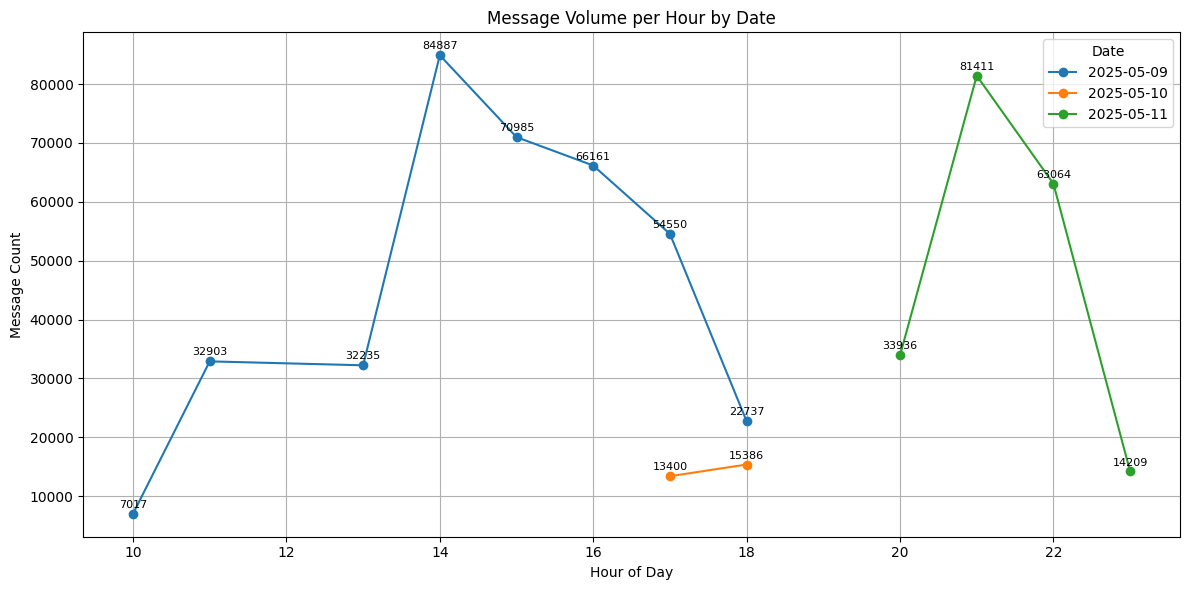

In [8]:

# Pivot for plotting
pivot = message_counts.pivot(index='hour', columns='date', values='message_count')

# Plot with markers
ax = pivot.plot(kind='line', marker='o', figsize=(12, 6))
plt.title("Message Volume per Hour by Date")
plt.xlabel("Hour of Day")
plt.ylabel("Message Count")
plt.grid(True)
plt.legend(title="Date")
plt.tight_layout()

# Add data labels
for date in pivot.columns:
    for hour, count in pivot[date].dropna().items():
        ax.text(hour, count + 1000, f'{int(count)}', ha='center', fontsize=8)

plt.show()


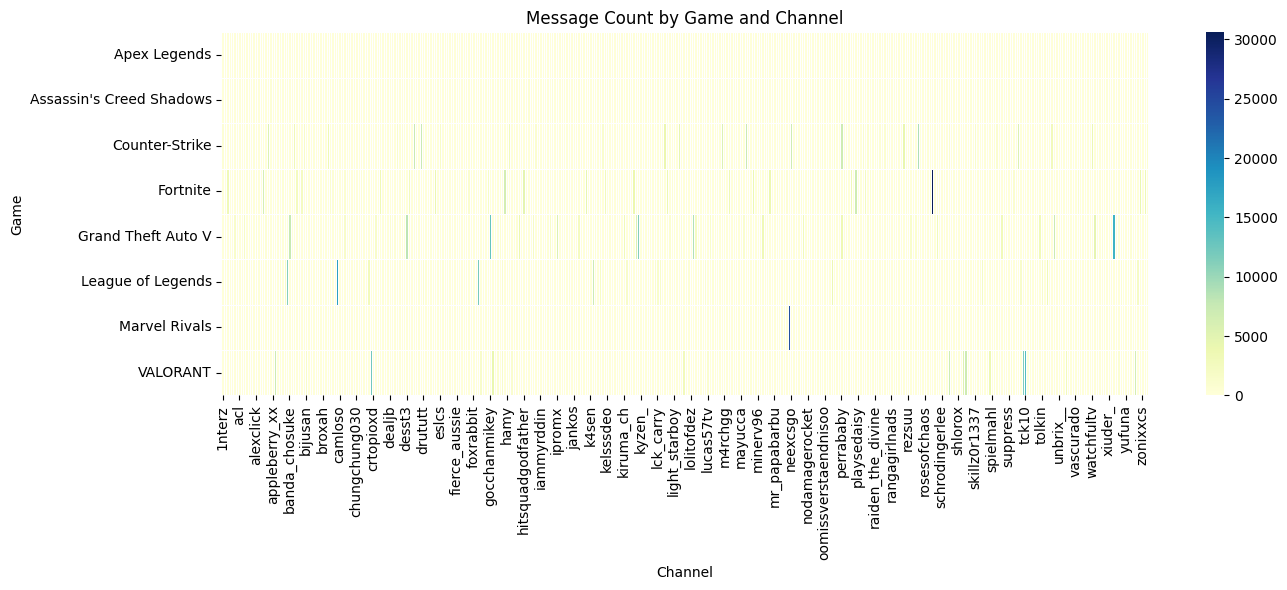

In [9]:


# Group by game_name and channel to count messages
game_channel_counts = df.groupby(['game_name', 'channel']).size().reset_index(name='message_count')

# Pivot for heatmap
heatmap_data = game_channel_counts.pivot(index='game_name', columns='channel', values='message_count').fillna(0)

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=0.5)
plt.title("Message Count by Game and Channel")
plt.xlabel("Channel")
plt.ylabel("Game")
plt.tight_layout()
plt.show()


In [10]:
df["date"] = df["timestamp"].dt.date
df["hour"] = df["timestamp"].dt.hour

In [11]:
df1 = df[
    (df["date"] == pd.to_datetime("2025-05-09").date()) &
    (df["hour"].between(14, 15))
]

In [12]:
df2 = df[
    (df["date"] == pd.to_datetime("2025-05-11").date()) &
    (df["hour"].between(21, 22))
]

In [16]:
def plot_heatmap(dataframe, title):
    count_matrix = dataframe.groupby(["game_name", "channel"]).size().unstack(fill_value=0)
    plt.figure(figsize=(10, 6))
    sns.heatmap(count_matrix,
                annot=False, # do not show data values.
                fmt="d",
                cmap="YlOrRd")
    plt.title(title)
    plt.xlabel("Channel")
    plt.ylabel("Game Name")
    plt.tight_layout()
    plt.show()

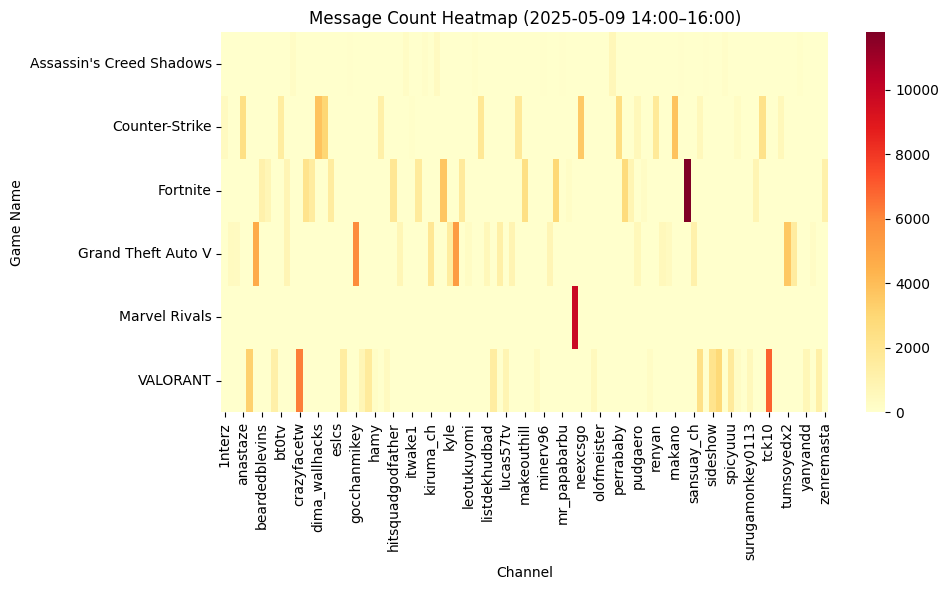

In [17]:
plot_heatmap(df1, "Message Count Heatmap (2025-05-09 14:00–16:00)")


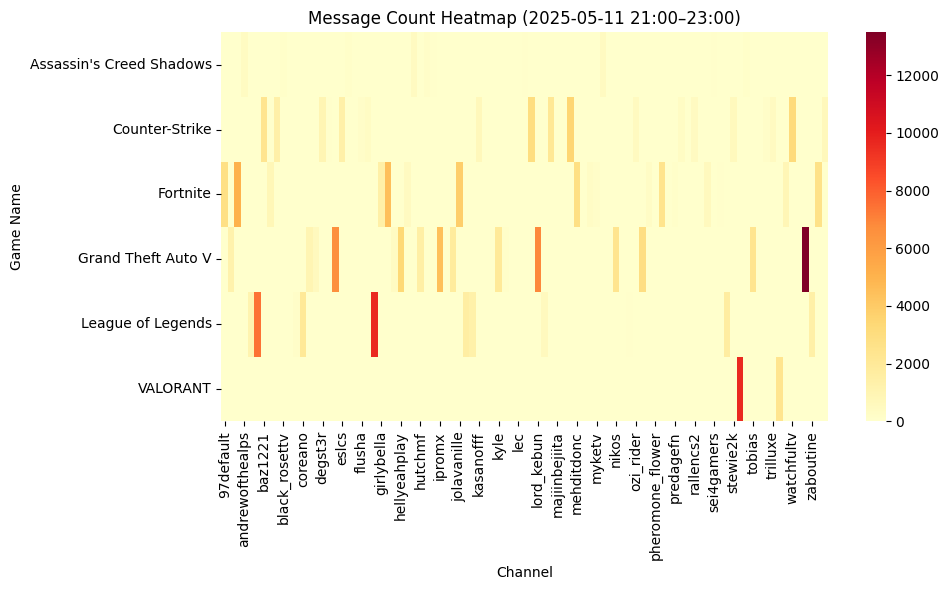

In [18]:
plot_heatmap(df2, "Message Count Heatmap (2025-05-11 21:00–23:00)")

check how many messages each user generate during each session.

In [19]:
user_msg_count_1 = df1["user_name"].value_counts()
user_msg_count_2 = df2["user_name"].value_counts()

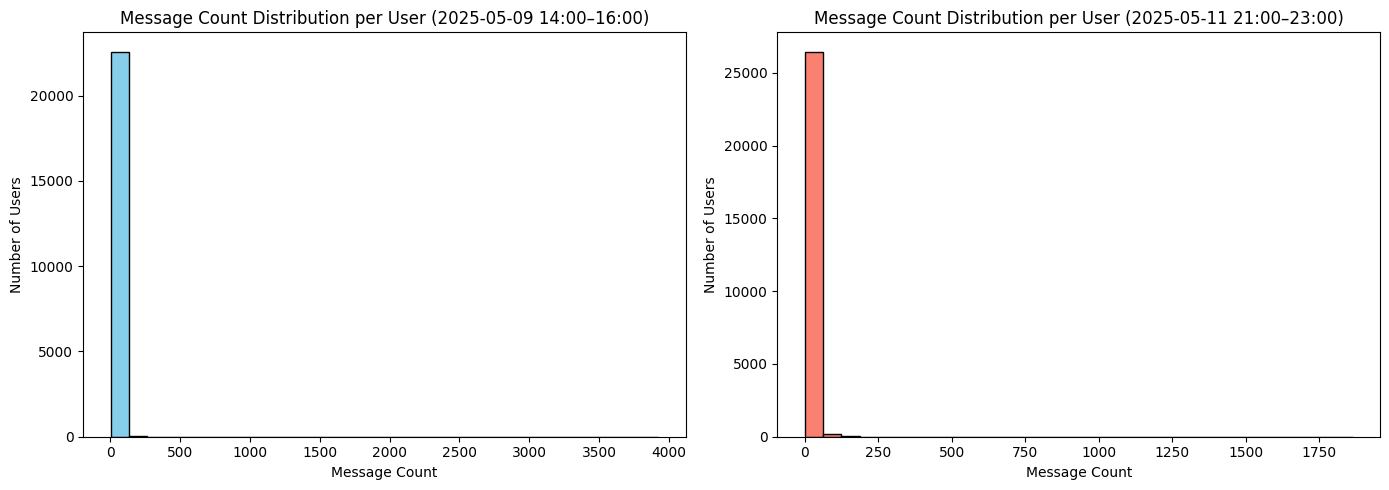

In [21]:
plt.figure(figsize=(14, 5))

# Session 1
plt.subplot(1, 2, 1)
user_msg_count_1.plot(kind="hist", bins=30, color="skyblue", edgecolor="black")
plt.title("Message Count Distribution per User (2025-05-09 14:00–16:00)")
plt.xlabel("Message Count")
plt.ylabel("Number of Users")

# Session 2
plt.subplot(1, 2, 2)
user_msg_count_2.plot(kind="hist", bins=30, color="salmon", edgecolor="black")
plt.title("Message Count Distribution per User (2025-05-11 21:00–23:00)")
plt.xlabel("Message Count")
plt.ylabel("Number of Users")

plt.tight_layout()
plt.show()

In [22]:
print("Session 1（2025-05-09 14–16）")
print(user_msg_count_1.describe())

Session 1（2025-05-09 14–16）
count    22634.000000
mean         6.886631
std         37.046123
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       3925.000000
Name: count, dtype: float64


In [23]:
print("\nSession 2（2025-05-11 21–23）")
print(user_msg_count_2.describe())


Session 2（2025-05-11 21–23）
count    26673.000000
mean         5.416526
std         20.227178
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max       1863.000000
Name: count, dtype: float64


check how many words each message contain.

In [26]:
# length of each message
df1.loc[:, "msg_length"] = df1["message"].str.len()
print(df1["msg_length"].describe())


count    155871.000000
mean         23.992468
std          37.252603
min           1.000000
25%           5.000000
50%          12.000000
75%          28.000000
max         501.000000
Name: msg_length, dtype: float64


In [27]:
# length of each message
df2.loc[:, "msg_length"] = df2["message"].str.len()
print(df2["msg_length"].describe())


count    144463.000000
mean         25.427570
std          35.595809
min           1.000000
25%           6.000000
50%          15.000000
75%          31.000000
max         500.000000
Name: msg_length, dtype: float64


<ipython-input-27-563444e180db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:, "msg_length"] = df2["message"].str.len()


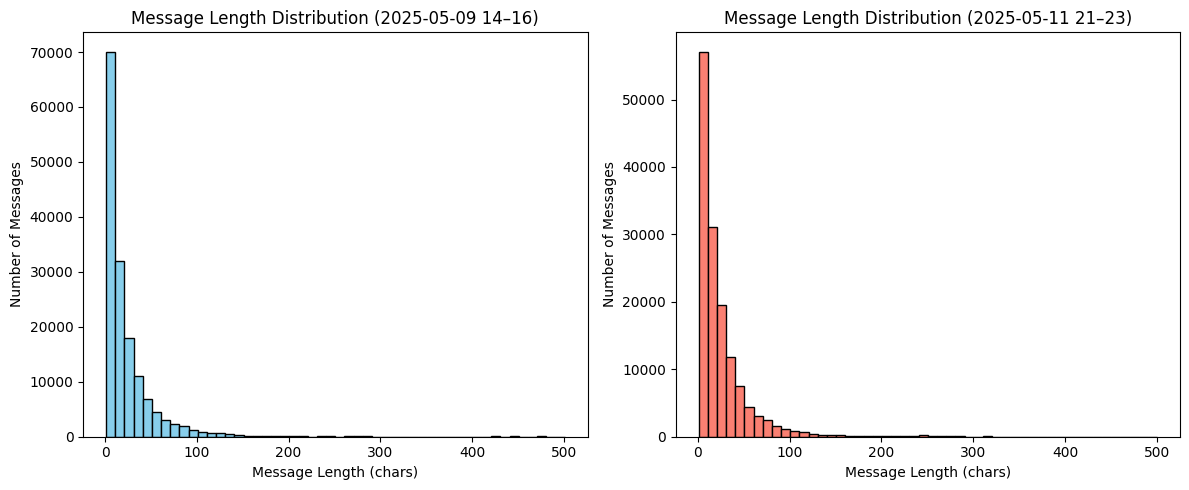

In [28]:
plt.figure(figsize=(12, 5))

# message length of df1
plt.subplot(1, 2, 1)
df1["msg_length"].plot(kind="hist", bins=50, color="skyblue", edgecolor="black")
plt.title("Message Length Distribution (2025-05-09 14–16)")
plt.xlabel("Message Length (chars)")
plt.ylabel("Number of Messages")

# message length of df2
plt.subplot(1, 2, 2)
df2["msg_length"].plot(kind="hist", bins=50, color="salmon", edgecolor="black")
plt.title("Message Length Distribution (2025-05-11 21–23)")
plt.xlabel("Message Length (chars)")
plt.ylabel("Number of Messages")

plt.tight_layout()
plt.show()

check for some active games, the distribution of message amounts and length.

In [29]:
games_df1 = ["Counter-Strike", "Fortnite", "Grand Theft Auto V", "Marvel Rivals", "VALORANT"]
games_df2 = ["Counter-Strike", "Fortnite", "Grand Theft Auto V", "League of Legends", "VALORANT"]


In [30]:
def print_game_describe(df, games, session_name):
    for game in games:
        print(f"\n====== {session_name} - {game} ======")

        game_df = df[df["game_name"] == game]

        # message count per user
        user_counts = game_df["user_name"].value_counts()
        print("\nUser Message Count (per user):")
        print(user_counts.describe())

        # messagen length descriptives.
        msg_lengths = game_df["message"].str.len()
        print("\nMessage Length (per message):")
        print(msg_lengths.describe())

In [31]:
print_game_describe(df1, games_df1, "Session 1 (2025-05-09)")



====== Session 1 (2025-05-09) - Counter-Strike ======

User Message Count (per user):
count    5950.000000
mean        5.415294
std        17.947959
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       857.000000
Name: count, dtype: float64

Message Length (per message):
count    32221.000000
mean        24.746315
std         32.523298
min          1.000000
25%          5.000000
50%         14.000000
75%         30.000000
max        497.000000
Name: message, dtype: float64

====== Session 1 (2025-05-09) - Fortnite ======

User Message Count (per user):
count    3858.000000
mean       10.413427
std        56.202013
min         1.000000
25%         1.000000
50%         2.000000
75%         7.000000
max      2404.000000
Name: count, dtype: float64

Message Length (per message):
count    40175.000000
mean        33.133815
std         51.945414
min          1.000000
25%          7.000000
50%         17.000000
75%         39.000000
max        496.000

In [32]:
print_game_describe(df2, games_df2, "Session 2 (2025-05-11)")


====== Session 2 (2025-05-11) - Counter-Strike ======

User Message Count (per user):
count    5286.000000
mean        4.234960
std        15.662259
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max       854.000000
Name: count, dtype: float64

Message Length (per message):
count    22386.000000
mean        29.830564
std         39.491132
min          1.000000
25%          6.000000
50%         18.000000
75%         37.000000
max        499.000000
Name: message, dtype: float64

====== Session 2 (2025-05-11) - Fortnite ======

User Message Count (per user):
count    4486.000000
mean        6.528979
std        23.437089
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       991.000000
Name: count, dtype: float64

Message Length (per message):
count    29282.000000
mean        27.277884
std         41.391218
min          1.000000
25%          6.000000
50%         15.000000
75%         32.000000
max        499.000

In [33]:
def plot_game_stats(df, games, title_prefix):
    fig, axes = plt.subplots(2, len(games), figsize=(5 * len(games), 8))

    for i, game in enumerate(games):
        game_df = df[df["game_name"] == game]

        # message count per user
        user_counts = game_df["user_name"].value_counts()
        axes[0, i].hist(user_counts, bins=30, color="skyblue", edgecolor="black")
        axes[0, i].set_title(f"{title_prefix} - {game}\nUser Message Count")
        axes[0, i].set_xlabel("Messages per User")
        axes[0, i].set_ylabel("User Count")

        # messagen length descriptives.
        msg_lengths = game_df["message"].str.len()
        axes[1, i].hist(msg_lengths, bins=50, color="salmon", edgecolor="black")
        axes[1, i].set_title(f"{title_prefix} - {game}\nMessage Length")
        axes[1, i].set_xlabel("Message Length (chars)")
        axes[1, i].set_ylabel("Message Count")

    plt.tight_layout()
    plt.show()


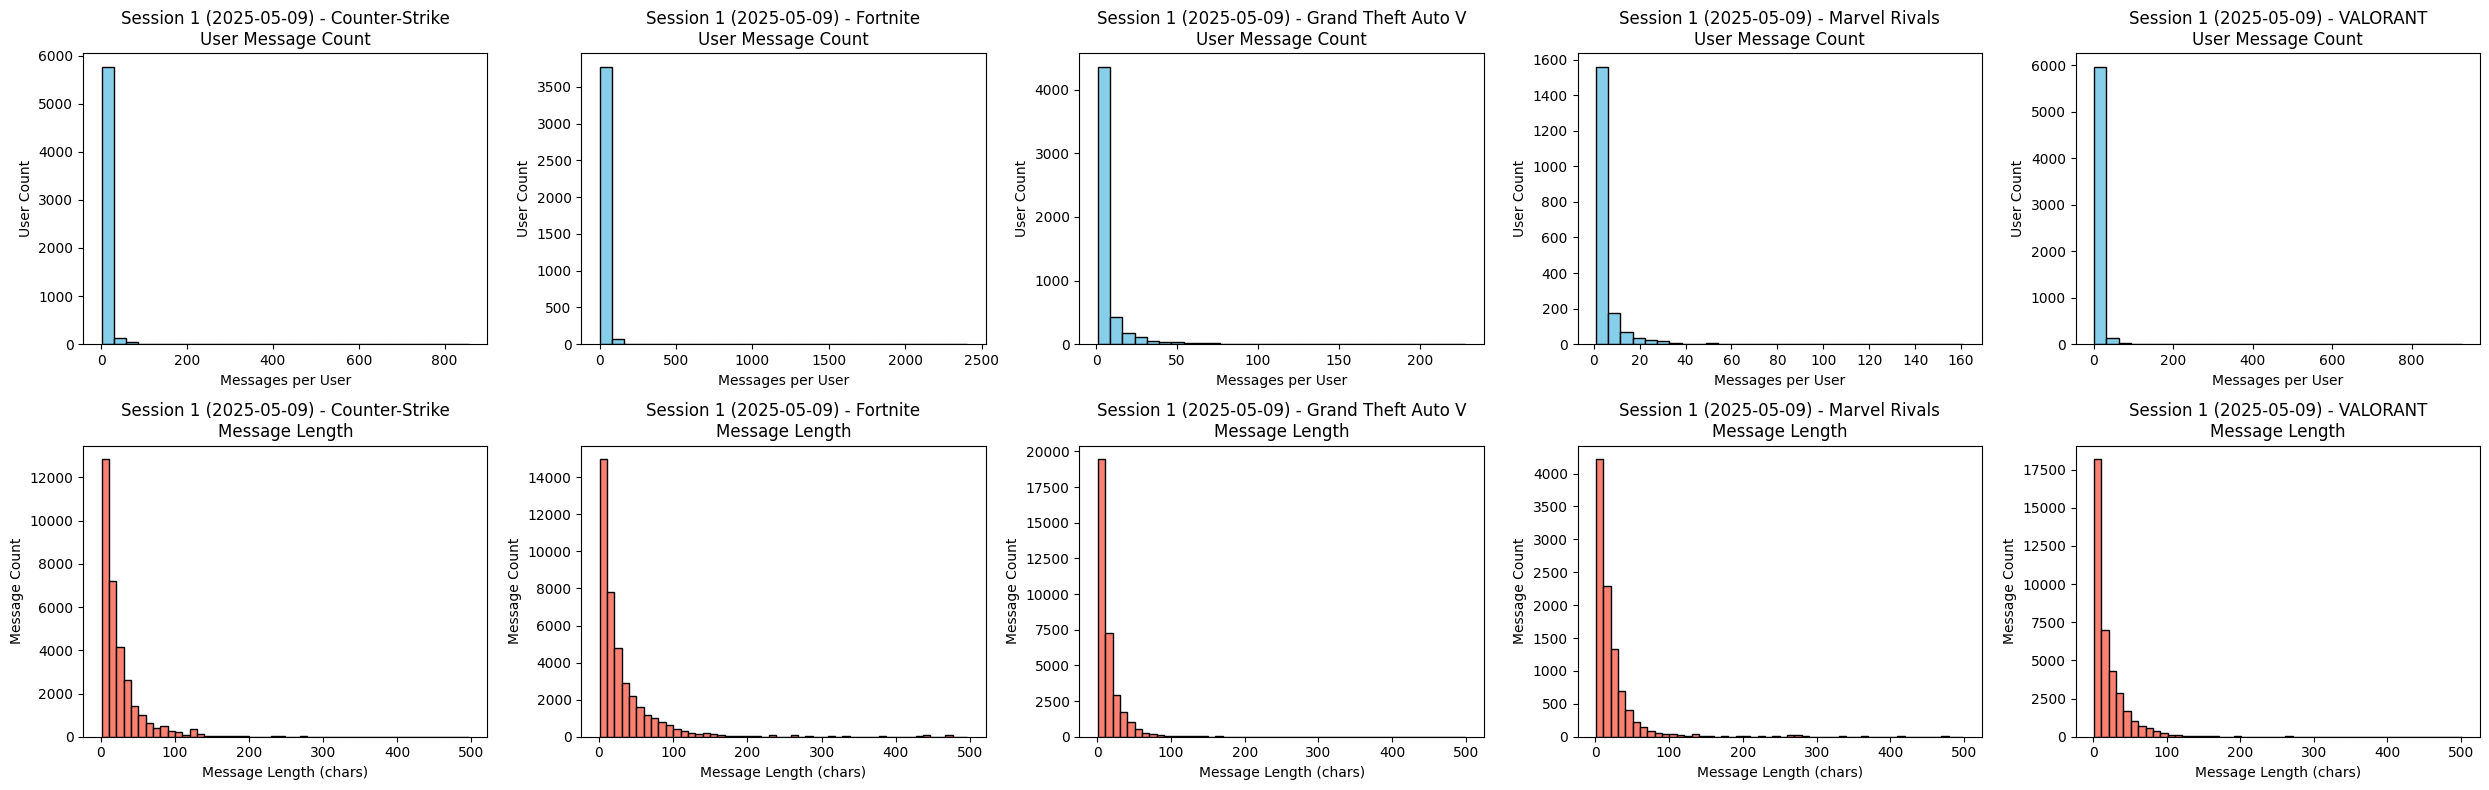

In [34]:
plot_game_stats(df1, games_df1, "Session 1 (2025-05-09)")

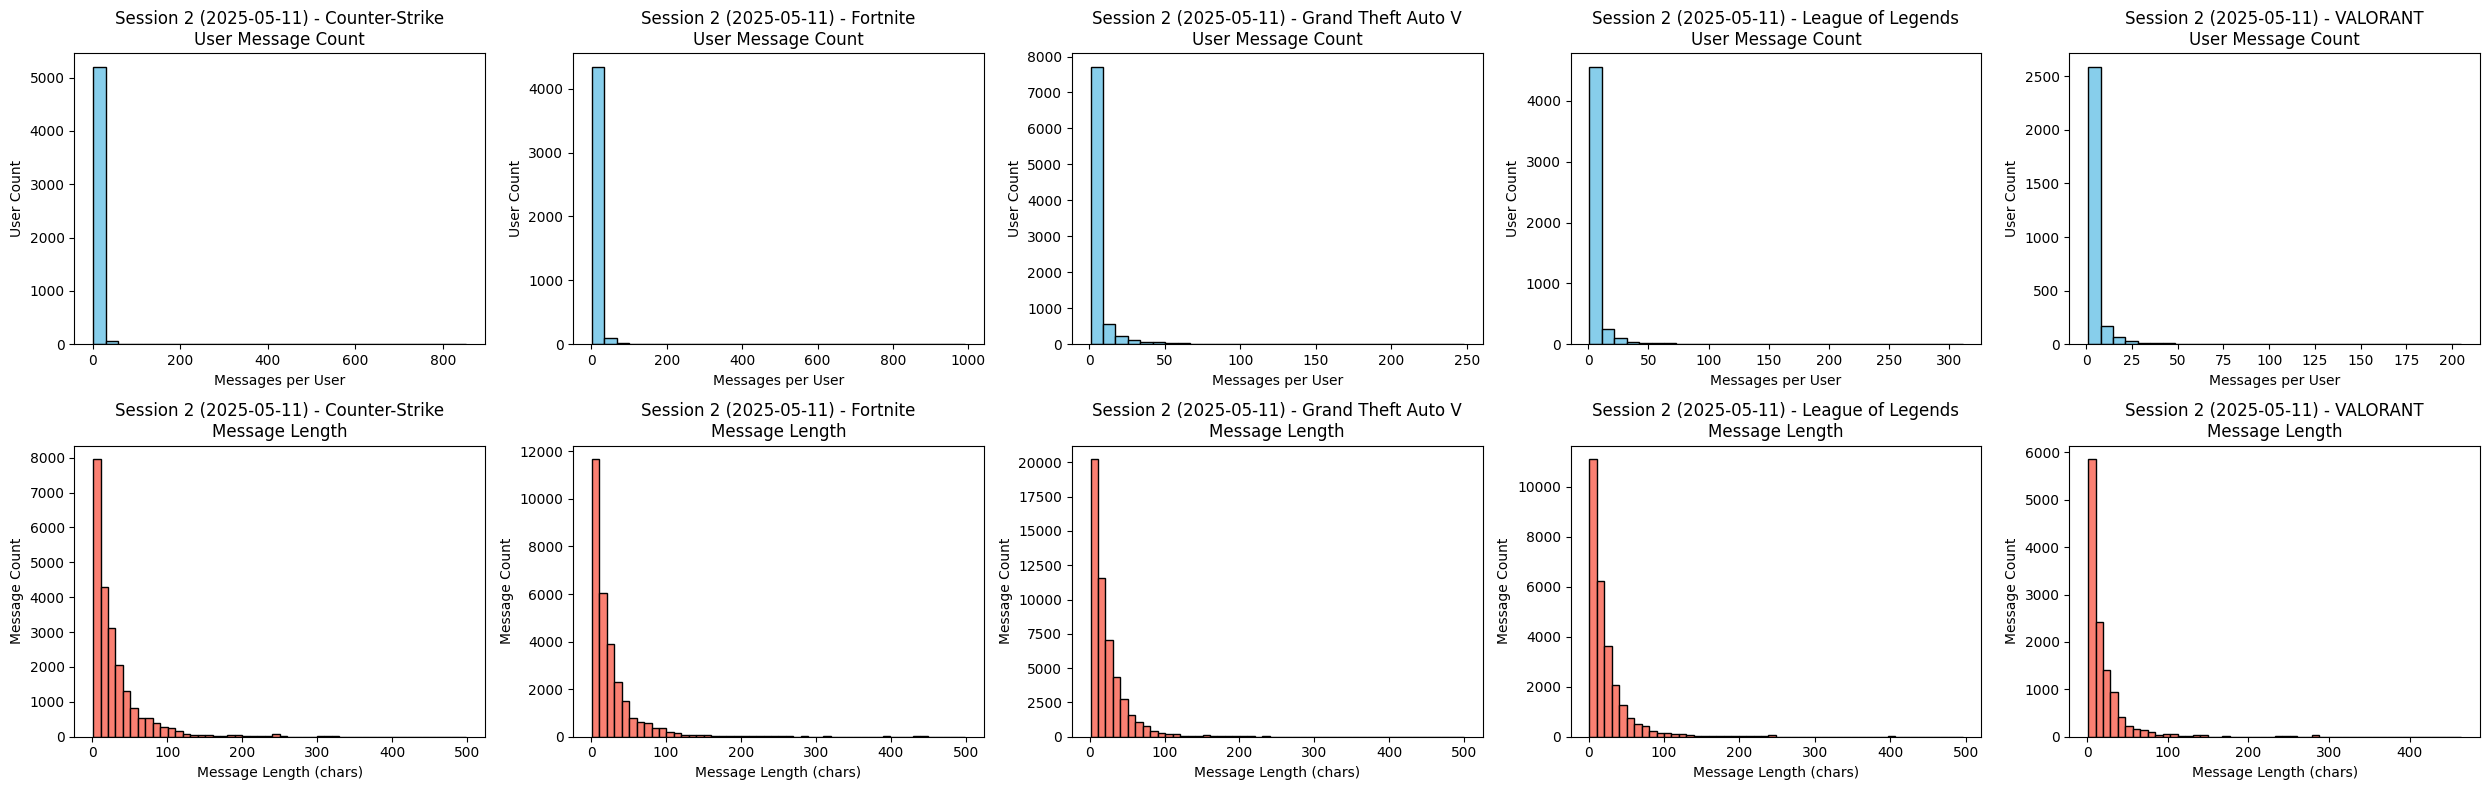

In [35]:
plot_game_stats(df2, games_df2, "Session 2 (2025-05-11)")

We choose active games with longer messages (median no less than 15 words) to do text modeling after studying the distribution of message amount and length.

# Text modeling